## Medical Appointment No Shows

### 1. Load Libraries

Below we will load all the required libraries. Libraries for reading CSV File, Basic EDA, Visualization and Data Modeling are all loaded in the below cell.

In [75]:
import pandas as pd
import numpy as np
import datetime
from time import strftime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [76]:
week_key = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

### 2. Load Data

In the below cell we will load the data from the CSV file in to a DataFrame. We will also check the row and column count by getting the shape of the data.

In [77]:
df = pd.read_csv('noshowappointments.csv')

In [78]:
print("The shape of the DataFrame is => {}".format(df.shape))

The shape of the DataFrame is => (110527, 14)


### 3. Basic Info of the Data

In the below cells we will see the basic information about the data that we had loaded in the previous step.

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


As can be seen above there are no NaN values in any of the columns.

In [80]:
# Print the top 5 rows
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### 4. Correct Incosistencies in Data

Below we will correct some of the inconsistencies in the data:

1. PatientId is an Integer and not Float. So, we will convert it into int64.
2. Data Type of ScheduledDay and AppointmentDay will be changed to DateTime.
3. Typo's in the Column names will be corrected
4. As the AppointmentDay has 00:00:00 in it's TimeStamp, we will ignore it.
5. As we removed the Time from AppointmentDay's TimeStamp we will do a similar thing for ScheduledDay also. (Ideally the Time in AppointmentDay column will help us better rather than in the ScheduledDay)

In [81]:
# Convert PatientId from Float to Integer
df['PatientId'] = df['PatientId'].astype('int64')

# Convert ScheduledDay and AppointmentDay from 'object' type to 'datetime64[ns]'
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date.astype('datetime64[ns]')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date.astype('datetime64[ns]')

# Rename incorrect column names.
df = df.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SMSReceived', 'No-show': 'NoShow'})

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null int64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SMSReceived       110527 non-null int64
NoShow            110527 non-null object
dtypes: datetime64[ns](2), int64(9), object(3)
memory usage: 11.8+ MB


In [83]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### 5. Data Wrangling, Feature Engineering and EDA

In [84]:
print("Features in the DataFrame => {}".format(df.columns.ravel()))

Features in the DataFrame => ['PatientId' 'AppointmentID' 'Gender' 'ScheduledDay' 'AppointmentDay' 'Age'
 'Neighbourhood' 'Scholarship' 'Hypertension' 'Diabetes' 'Alcoholism'
 'Handicap' 'SMSReceived' 'NoShow']


From the above Info of the DataFrame and the sample data we can see that there are 14 columns in total.

 - There are 13 Independent Variables -> ['PatientId' 'AppointmentID' 'Gender' 'ScheduledDay' 'AppointmentDay' 'Age' 'Neighbourhood' 'Scholarship' 'Hypertension' 'Diabetes' 'Alcoholism' 'Handicap' 'SMSReceived']
 - The Dependent Variable is -> ['NoShow']

Below, we will drop 'PatientId' and 'AppointmentID' from the dataframe as they are just some system genrated numbers and shouldn't be used for predicting the dependent variable.

In [85]:
# Drop 'PatientId' and 'AppointmentID' as they are just some system genrated numbers.
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)

In [86]:
# Print Unique Values
print("Unique Values in `Gender` => {}".format(df.Gender.unique()))
print("Unique Values in `Scholarship` => {}".format(df.Scholarship.unique()))
print("Unique Values in `Hypertension` => {}".format(df.Hypertension.unique()))
print("Unique Values in `Diabetes` => {}".format(df.Diabetes.unique()))
print("Unique Values in `Alcoholism` => {}".format(df.Alcoholism.unique()))
print("Unique Values in `Handicap` => {}".format(df.Handicap.unique()))
print("Unique Values in `SMSReceived` => {}".format(df.SMSReceived.unique()))

Unique Values in `Gender` => ['F' 'M']
Unique Values in `Scholarship` => [0 1]
Unique Values in `Hypertension` => [1 0]
Unique Values in `Diabetes` => [0 1]
Unique Values in `Alcoholism` => [0 1]
Unique Values in `Handicap` => [0 1 2 3 4]
Unique Values in `SMSReceived` => [0 1]


From the above detail we can see that except for `Handicap` which has four values and `Gender` which has 'M' and 'F' all the other features have 'Yes' or 'No' kind of values. So, we will convert those columns to `'object'` type.

In [87]:
df['Scholarship'] = df['Scholarship'].astype('object')
df['Hypertension'] = df['Hypertension'].astype('object')
df['Diabetes'] = df['Diabetes'].astype('object')
df['Alcoholism'] = df['Alcoholism'].astype('object')
df['Handicap'] = df['Handicap'].astype('object')
df['SMSReceived'] = df['SMSReceived'].astype('object')

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 12 columns):
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null object
Hypertension      110527 non-null object
Diabetes          110527 non-null object
Alcoholism        110527 non-null object
Handicap          110527 non-null object
SMSReceived       110527 non-null object
NoShow            110527 non-null object
dtypes: datetime64[ns](2), int64(1), object(9)
memory usage: 10.1+ MB


In [89]:
# Print some sample data
df.sample(n=5)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
13432,M,2016-05-30,2016-05-31,36,ITARARÉ,0,0,0,1,0,0,No
85764,M,2016-06-07,2016-06-07,40,JARDIM CAMBURI,0,0,0,0,0,0,No
21687,F,2016-05-16,2016-05-18,61,BELA VISTA,0,1,0,0,0,0,No
66837,F,2016-03-01,2016-05-09,60,JARDIM CAMBURI,0,0,0,0,0,0,Yes
26671,M,2016-05-10,2016-05-17,24,SANTO ANDRÉ,0,0,0,0,1,0,No


In [90]:
# Print Unique Values for 'Age'
print("Unique Values in `Age` => {}".format(np.sort(df.Age.unique())))

Unique Values in `Age` => [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 102 115]


In the below code we will check few details about the patients with `Age` `0` and `-1`.

In [91]:
print("Patients with `Age` less than -1 -> {}".format(df[df.Age == -1].shape[0]))
print("Patients with `Age` equal to 0 -> {}".format(df[df.Age == 0].shape[0]))

Patients with `Age` less than -1 -> 1
Patients with `Age` equal to 0 -> 3539


As there is only 1 patient with `Age` less than 0 we will delete that record assuming that they was a typo.

In [92]:
df = df[df.Age >= 0]

As we have 3539 patients with `Age` equal to 0 we are assuming that these are the small babies with few months of Age. Usually as babies doesn't have `Hypertension` or `Diabetes` or `Alcoholism` we will check these features for the above records to see if our assumption is correct.

In [93]:
df[(df.Age <= 0) & ((df.Hypertension.astype(int) == 1) | (df.Diabetes.astype(int) == 1) | (df.Alcoholism.astype(int) == 1))]

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow


As we have no records above, we will confirm our conclusion that `Age` value of 0 indeed represents babies who are just few months old.

In [94]:
# Print Unique Values for 'ScheduledDay'
print("Unique Values in `ScheduledDay` => {}".format(np.sort(df.ScheduledDay.dt.strftime('%Y-%m-%d').unique())))

Unique Values in `ScheduledDay` => ['2015-11-10' '2015-12-03' '2015-12-07' '2015-12-08' '2015-12-14'
 '2015-12-15' '2016-01-04' '2016-01-05' '2016-01-07' '2016-01-11'
 '2016-01-13' '2016-01-14' '2016-01-19' '2016-01-20' '2016-01-21'
 '2016-01-22' '2016-01-25' '2016-01-26' '2016-01-27' '2016-01-28'
 '2016-01-29' '2016-02-01' '2016-02-02' '2016-02-03' '2016-02-04'
 '2016-02-05' '2016-02-11' '2016-02-12' '2016-02-15' '2016-02-16'
 '2016-02-17' '2016-02-18' '2016-02-19' '2016-02-22' '2016-02-23'
 '2016-02-24' '2016-02-25' '2016-02-26' '2016-02-29' '2016-03-01'
 '2016-03-02' '2016-03-03' '2016-03-04' '2016-03-05' '2016-03-07'
 '2016-03-08' '2016-03-09' '2016-03-10' '2016-03-11' '2016-03-14'
 '2016-03-15' '2016-03-16' '2016-03-17' '2016-03-18' '2016-03-19'
 '2016-03-21' '2016-03-22' '2016-03-23' '2016-03-28' '2016-03-29'
 '2016-03-30' '2016-03-31' '2016-04-01' '2016-04-05' '2016-04-06'
 '2016-04-07' '2016-04-08' '2016-04-09' '2016-04-11' '2016-04-12'
 '2016-04-13' '2016-04-14' '2016-04-15' '

We can see from the above details that the `ScheduledDay` for appointments are ranging from **2015-11-10** to **2016-06-08** and that's around 7 months of data.

In [95]:
# Print Unique Values for 'AppointmentDay'
print("Unique Values in `AppointmentDay` => {}".format(np.sort(df.AppointmentDay.dt.strftime('%Y-%m-%d').unique())))

Unique Values in `AppointmentDay` => ['2016-04-29' '2016-05-02' '2016-05-03' '2016-05-04' '2016-05-05'
 '2016-05-06' '2016-05-09' '2016-05-10' '2016-05-11' '2016-05-12'
 '2016-05-13' '2016-05-14' '2016-05-16' '2016-05-17' '2016-05-18'
 '2016-05-19' '2016-05-20' '2016-05-24' '2016-05-25' '2016-05-30'
 '2016-05-31' '2016-06-01' '2016-06-02' '2016-06-03' '2016-06-06'
 '2016-06-07' '2016-06-08']


From the above detail we can see that `AppointmentDay` ranges from **2016-04-29** to **2016-06-08**. The `AppointmentDay` spans just above 1 Month in contrast to the `ScheduledDay` that spans around 7 Months.

In [96]:
# Print Unique Values for 'Neighbourhood'
print("Unique Values in `Neighbourhood` => {}".format(np.sort(df.Neighbourhood.unique())))

Unique Values in `Neighbourhood` => ['AEROPORTO' 'ANDORINHAS' 'ANTÔNIO HONÓRIO' 'ARIOVALDO FAVALESSA'
 'BARRO VERMELHO' 'BELA VISTA' 'BENTO FERREIRA' 'BOA VISTA' 'BONFIM'
 'CARATOÍRA' 'CENTRO' 'COMDUSA' 'CONQUISTA' 'CONSOLAÇÃO' 'CRUZAMENTO'
 'DA PENHA' 'DE LOURDES' 'DO CABRAL' 'DO MOSCOSO' 'DO QUADRO'
 'ENSEADA DO SUÁ' 'ESTRELINHA' 'FONTE GRANDE' 'FORTE SÃO JOÃO' 'FRADINHOS'
 'GOIABEIRAS' 'GRANDE VITÓRIA' 'GURIGICA' 'HORTO' 'ILHA DAS CAIEIRAS'
 'ILHA DE SANTA MARIA' 'ILHA DO BOI' 'ILHA DO FRADE' 'ILHA DO PRÍNCIPE'
 'ILHAS OCEÂNICAS DE TRINDADE' 'INHANGUETÁ' 'ITARARÉ' 'JABOUR'
 'JARDIM CAMBURI' 'JARDIM DA PENHA' 'JESUS DE NAZARETH' 'JOANA D´ARC'
 'JUCUTUQUARA' 'MARIA ORTIZ' 'MARUÍPE' 'MATA DA PRAIA' 'MONTE BELO'
 'MORADA DE CAMBURI' 'MÁRIO CYPRESTE' 'NAZARETH' 'NOVA PALESTINA'
 'PARQUE INDUSTRIAL' 'PARQUE MOSCOSO' 'PIEDADE' 'PONTAL DE CAMBURI'
 'PRAIA DO CANTO' 'PRAIA DO SUÁ' 'REDENÇÃO' 'REPÚBLICA' 'RESISTÊNCIA'
 'ROMÃO' 'SANTA CECÍLIA' 'SANTA CLARA' 'SANTA HELENA' 'SANTA LUÍZA'
 'SANTA

In [97]:
# Print Total Count for 'Neighbourhood'
print("Total Count for `Neighbourhood` => {}".format(df.Neighbourhood.unique().size))

Total Count for `Neighbourhood` => 81


Get Day of the Week for `ScheduledDay` and `AppointmentDay` to see if there are many 'NoShows' over the weekends.
Week for `ScheduledDay` and `AppointmentDay` also helps us to see if there is a particular pattern where most patients are coming for a visit.

In [98]:
# Get Day of the Week for ScheduledDay and AppointmentDay
df['ScheduledDay_DOW'] = df['ScheduledDay'].dt.weekday_name
df['AppointmentDay_DOW'] = df['AppointmentDay'].dt.weekday_name

Ideally the `AppointmentDay` should be on or after the `ScheduledDay`. Below we will check if there are any records where there is an inconsistency. In case if the `ScheduledDay` is after the `AppointmentDay` we will consider it as an error and correct the `ScheduledDay` to the `AppointmentDay`.

In [99]:
df['AppointmentDay'] = np.where((df['AppointmentDay'] - df['ScheduledDay']).dt.days < 0, df['ScheduledDay'], df['AppointmentDay'])

# Get the Waiting Time in Days of the Patients.
df['Waiting_Time_days'] = df['AppointmentDay'] - df['ScheduledDay']
df['Waiting_Time_days'] = df['Waiting_Time_days'].dt.days

In [100]:
# Sanity check to see if the Waiting Time is less than Zero for any of the data points.
print("There are [{}] records where the Waiting Time is less than Zero.".format(df[df.Waiting_Time_days < 0].shape[0]))

There are [0] records where the Waiting Time is less than Zero.


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 15 columns):
Gender                110526 non-null object
ScheduledDay          110526 non-null datetime64[ns]
AppointmentDay        110526 non-null datetime64[ns]
Age                   110526 non-null int64
Neighbourhood         110526 non-null object
Scholarship           110526 non-null object
Hypertension          110526 non-null object
Diabetes              110526 non-null object
Alcoholism            110526 non-null object
Handicap              110526 non-null object
SMSReceived           110526 non-null object
NoShow                110526 non-null object
ScheduledDay_DOW      110526 non-null object
AppointmentDay_DOW    110526 non-null object
Waiting_Time_days     110526 non-null int64
dtypes: datetime64[ns](2), int64(2), object(11)
memory usage: 18.5+ MB


In [102]:
df.sample(n=10)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,ScheduledDay_DOW,AppointmentDay_DOW,Waiting_Time_days
90248,F,2016-06-01,2016-06-08,12,BONFIM,0,0,0,0,0,0,Yes,Wednesday,Wednesday,7
101298,M,2016-06-01,2016-06-02,14,CENTRO,0,0,0,0,0,0,Yes,Wednesday,Thursday,1
78084,F,2016-05-16,2016-05-16,69,SANTA MARTHA,0,1,0,0,0,0,No,Monday,Monday,0
31666,M,2016-05-06,2016-05-06,1,DO CABRAL,0,0,0,0,0,0,No,Friday,Friday,0
41528,F,2016-05-19,2016-05-25,38,JARDIM CAMBURI,0,0,0,0,0,0,No,Thursday,Wednesday,6
2714,M,2016-04-29,2016-04-29,16,SÃO PEDRO,0,0,0,0,0,0,Yes,Friday,Friday,0
1814,M,2016-04-25,2016-04-29,26,CRUZAMENTO,0,0,0,0,0,1,No,Monday,Friday,4
102662,F,2016-06-06,2016-06-07,30,SÃO JOSÉ,0,0,0,0,0,0,No,Monday,Tuesday,1
101045,M,2016-06-06,2016-06-06,59,SANTA MARTHA,1,0,0,0,0,0,No,Monday,Monday,0
45417,F,2016-05-16,2016-05-16,19,ESTRELINHA,0,0,0,0,0,0,Yes,Monday,Monday,0


In [103]:
print("NoShow and Show Count of Patients\n")
print(df.groupby(['NoShow']).size())

print("\nNoShow and Show '%' of Patients\n")
show = df.groupby(['NoShow']).size()[0]/(df.groupby(['NoShow']).size()[0]+df.groupby(['NoShow']).size()[1])
print("Percent of Patients who `Showed Up` => {:.2f}%".format(show*100))
noshow = df.groupby(['NoShow']).size()[1]/(df.groupby(['NoShow']).size()[0]+df.groupby(['NoShow']).size()[1])
print("Percent of Patients who Did `Not Showed Up` => {:.2f}%".format(noshow*100))

NoShow and Show Count of Patients

NoShow
No     88207
Yes    22319
dtype: int64

NoShow and Show '%' of Patients

Percent of Patients who `Showed Up` => 79.81%
Percent of Patients who Did `Not Showed Up` => 20.19%


From the above information we can see that there is clearly a class imbalance. Around 80% of the patients are coming for the visit after an appointment and around 20% are skipping their appointments.

### 5. Data Visualization

#### 5.0 Show/NoShow

Below we can see that out of 110,500 patients around 88,000 of them have turned up and that's around 80%.

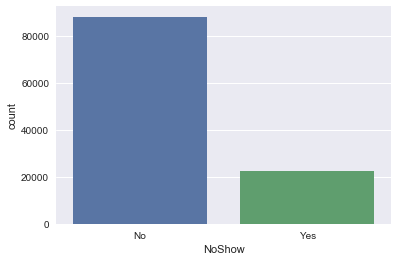

In [104]:
_ = sns.countplot(x=df.NoShow, data=df)

#### 5.1 Gender

- Below we can see that out of the 88,000 patients that have turned up, around 57,000 of them are Females and 31,000 are Males.
- Of the 22,500 patients that haven't come for the visit around 15,000 are Females and 7,500 are Males
- The ratio of Females to Males that have turned up looks simiar to those who haven't come for a visit.

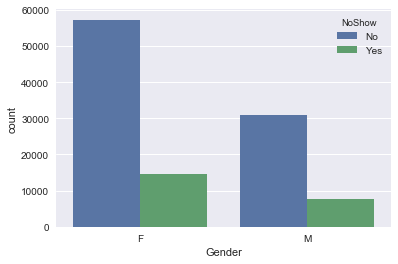

In [105]:
_ = sns.countplot(x=df.Gender, hue=df.NoShow, data=df)

From the above visualization we can clearly see that 'Female' patients usually have more appointments that 'Male' patients. So, **Gender** might be an important factor. But if we closely look at the NoShow distribution across Male's and Female's it is almost the same. So, **Gender** may not play an important role in determining if a patient comes for a visit or not.

#### 5.2 Age

We will draw a boxplot for the `Age` feature to check it's distribution.

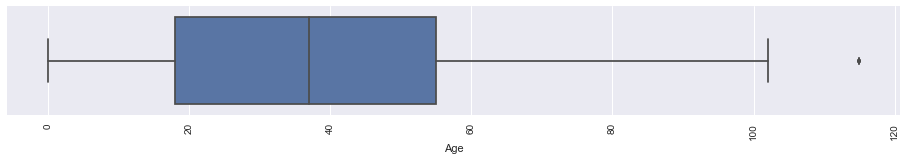

In [106]:
plt.figure(figsize=(16,2))
plt.xticks(rotation=90)
_ = sns.boxplot(x=df.Age)

From the above `BoxPlot` we can see that the Median Age is around 30 and the IQR is between 18 and 55.
Though the BoxPlot shows few datapoints as outliers we will not consider them as true outliers for this case.

Below we will plot the number of patients for different Age.

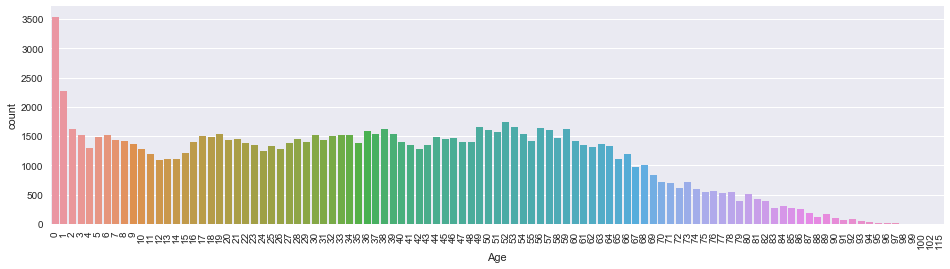

In [107]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
_ = sns.countplot(x=df.Age)

From the above Histogram we can see that there are peaks for the Infants and then the distribution starts to be uniform. Later, after the Age of around 60 we see a right-skewed distribution.

Below we will plot the Show/NoShow for the patients based on their Age.

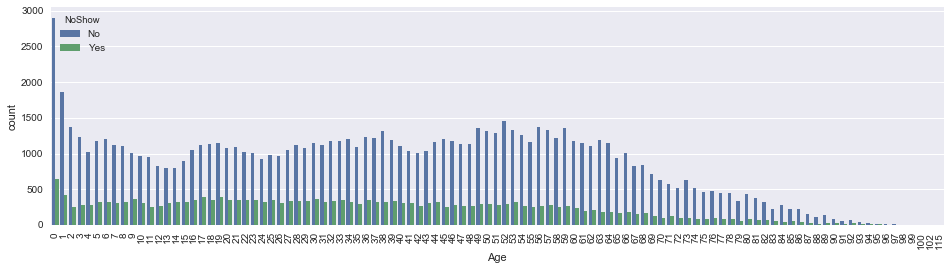

In [108]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
_ = sns.countplot(x=df.Age, hue=df.NoShow)

From the above visualization looks like the ratio of Show to NoShow is almost the same for all Age's except for 'Age 0' and 'Age 1'. We will get a better clarity on the ratio of Show to NoShow for all Age's.

In [109]:
df_age_ratio = df[df.NoShow == 'No'].groupby(['Age']).size()/df.groupby(['Age']).size()

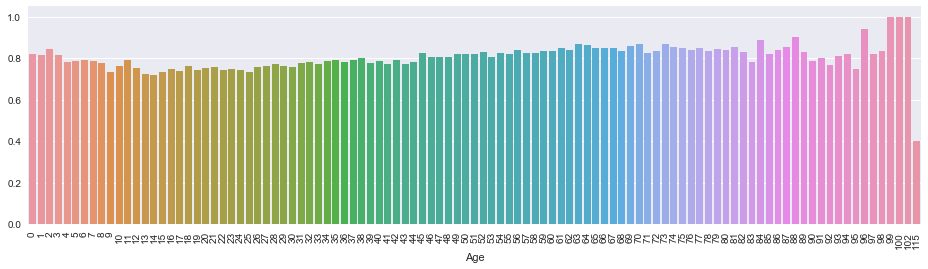

In [110]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
_ = sns.barplot(x=df_age_ratio.index, y=df_age_ratio)

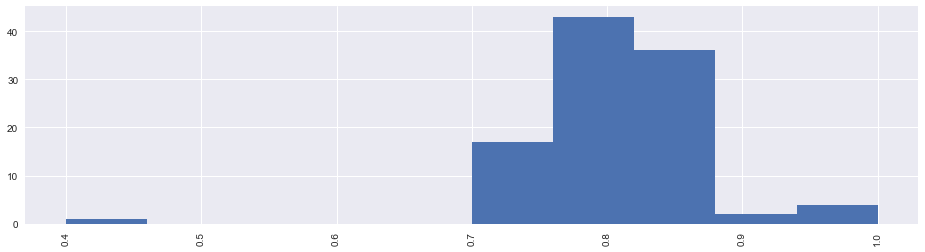

In [111]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
_ = plt.hist(df_age_ratio)

From the above visualization we could clearly see that most of the Age group patients have around 80% Show rate.

#### 5.3 Neighbourhood

Below we will see the patients count for each Neighbourhood.

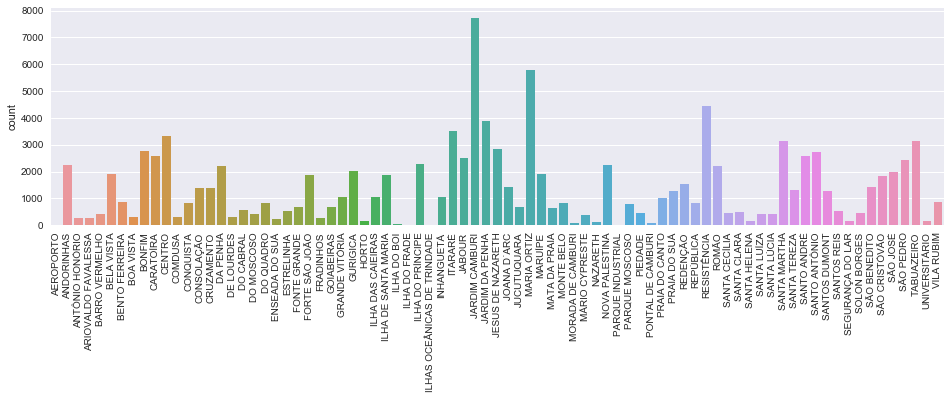

In [112]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
_ = sns.countplot(x=np.sort(df.Neighbourhood))

From the above visualization we can see that the number of patients for few Neighbourhood's is very high.

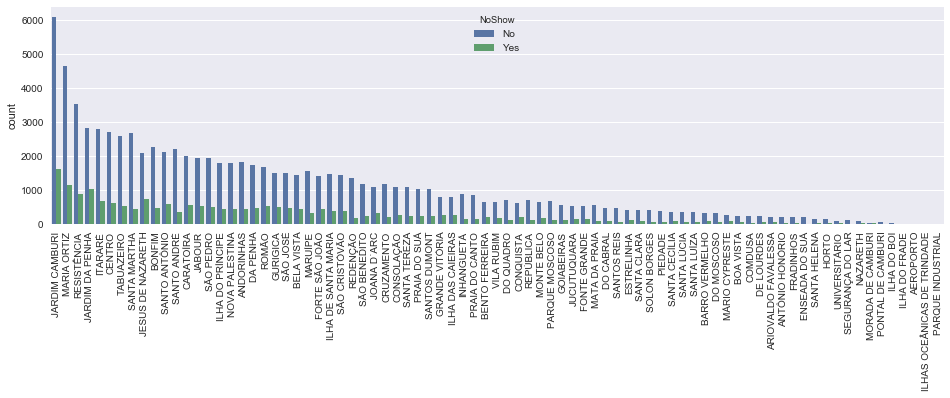

In [113]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
_ = sns.countplot(x=np.sort(df.Neighbourhood), hue=df.NoShow, order=df.Neighbourhood.value_counts().index)

From the above visualization looks like the ratio of Show to NoShow is almost the same for all Neighbourhood's. We will get a better clarity on the ratio of Show to NoShow for all Neighbourhood's in the below visualization.

In [114]:
df_n_ratio = df[df.NoShow == 'No'].groupby(['Neighbourhood']).size()/df.groupby(['Neighbourhood']).size()

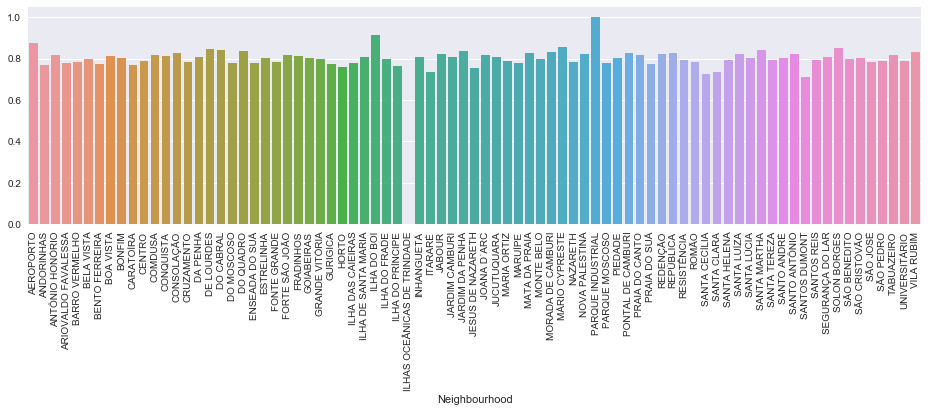

In [115]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
_ = sns.barplot(x=df_n_ratio.index, y=df_n_ratio)

As most of the Neighbourhood have around 80% Show rate, this feature may not add much value while building a model to help us determine which segment of patients are tuning up for a visit the most.

#### 5.4 Scholarship

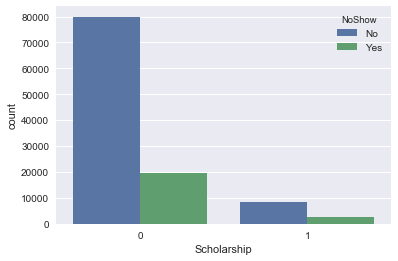

In [116]:
scholarship_values = [0, 1]
scholarship_labels = ['No', 'Yes']
fig, ax = plt.subplots(1,1)

ax.set_xticks(scholarship_values)
ax.set_xticklabels(scholarship_labels, minor=False)

ax = sns.countplot(x=df.Scholarship, hue=df.NoShow, data=df)

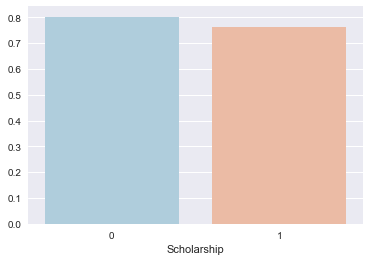

In [117]:
df_s_ratio = df[df.NoShow == 'No'].groupby(['Scholarship']).size()/df.groupby(['Scholarship']).size()
_ = sns.barplot(x=df_s_ratio.index, y=df_s_ratio, palette="RdBu_r")

- From the above visualization we can see that there are around 100,000 patients without Scholarship and out of them around 80% have come for the visit.
- Out of the 10,500 patients with Scholarship around 75% of them have come for the visit.

So, Scholarship feature could help us in determining if a patient will turn up for the visit after an appointment.

#### 5.5 Hypertension

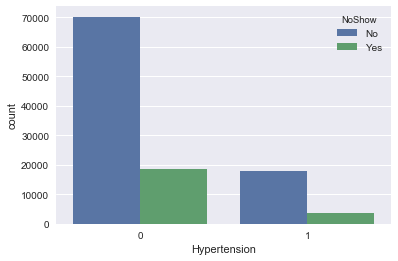

In [118]:
_ = sns.countplot(x=df.Hypertension, hue=df.NoShow, data=df)

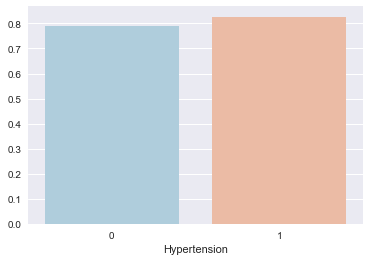

In [119]:
df_h_ratio = df[df.NoShow == 'No'].groupby(['Hypertension']).size()/df.groupby(['Hypertension']).size()
_ = sns.barplot(x=df_h_ratio.index, y=df_h_ratio, palette="RdBu_r")

- From the above visualization we can see that there are around 88,000 patients without Hypertension and out of them around 78% have come for the visit.
- Out of the 22,500 patients with Hypertension around 85% of them have come for the visit.

So, Hypertension feature could help us in determining if a patient will turn up for the visit after an appointment.

#### 5.6 Diabetes

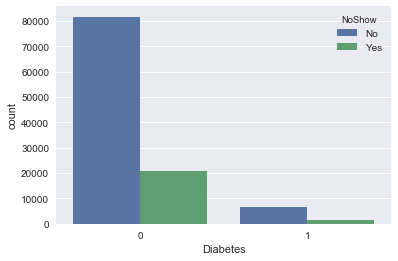

In [120]:
_ = sns.countplot(x=df.Diabetes, hue=df.NoShow, data=df)

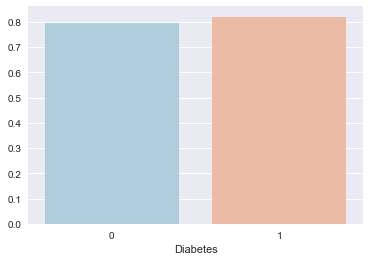

In [121]:
df_d_ratio = df[df.NoShow == 'No'].groupby(['Diabetes']).size()/df.groupby(['Diabetes']).size()
_ = sns.barplot(x=df_d_ratio.index, y=df_d_ratio, palette="RdBu_r")

- From the above visualization we can see that there are around 102,000 patients without Diabetes and out of them around 80% have come for the visit.
- Out of the 8,500 patients with Diabetes around 83% of them have come for the visit.

So, Diabetes feature could help us in determining if a patient will turn up for the visit after an appointment.

#### 5.7 Alcoholism

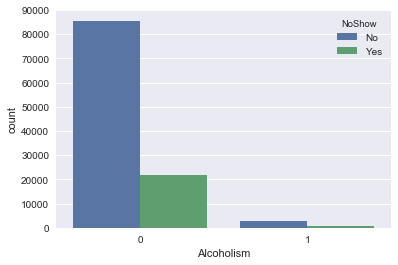

In [122]:
_ = sns.countplot(x=df.Alcoholism, hue=df.NoShow, data=df)

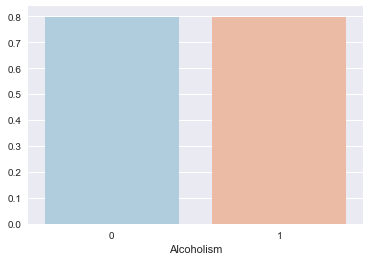

In [123]:
df_a_ratio = df[df.NoShow == 'No'].groupby(['Alcoholism']).size()/df.groupby(['Alcoholism']).size()
_ = sns.barplot(x=df_a_ratio.index, y=df_a_ratio, palette="RdBu_r")

- From the above visualization we can see that there are around 105,000 patients without Alcoholism and out of them around 80% have come for the visit.
- Out of the 5,500 patients with Alcoholism around 80% of them have come for the visit.

As the percentage of visits for patients with and without Alcoholism is the same it may not help us in determining if a patient will come for a visit.

#### 5.8 Handicap

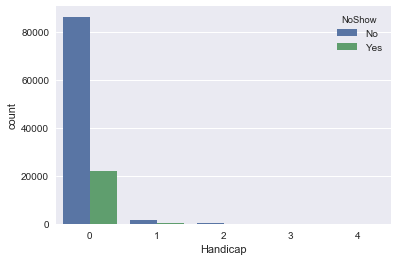

In [124]:
_ = sns.countplot(x=df.Handicap, hue=df.NoShow, data=df)

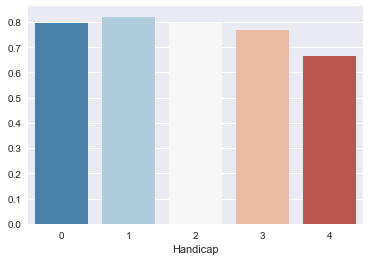

In [125]:
df_ha_ratio = df[df.NoShow == 'No'].groupby(['Handicap']).size()/df.groupby(['Handicap']).size()
_ = sns.barplot(x=df_ha_ratio.index, y=df_ha_ratio, palette="RdBu_r")

- From the above visualization we can see that there are around 110,000 patients without Handicap and out of them around 80% have come for the visit.

As we can see a clear distinction between different Handicap levels this feature will help us in determining if a patient will turn up for the visit after taking an appointment.

#### 5.9 SMSReceived

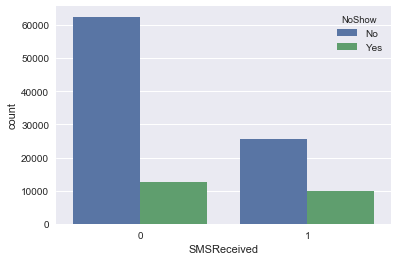

In [126]:
_ = sns.countplot(x=df.SMSReceived, hue=df.NoShow, data=df)

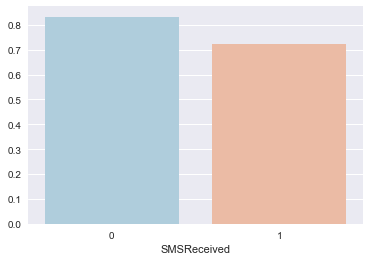

In [127]:
df_s_ratio = df[df.NoShow == 'No'].groupby(['SMSReceived']).size()/df.groupby(['SMSReceived']).size()
_ = sns.barplot(x=df_s_ratio.index, y=df_s_ratio, palette="RdBu_r")

- From the above visualization we can see that there are around 75,000 patients who have not received SMS and out of them around 84% have come for the visit.
- Out of the 35,500 patients who have received SMS around 72% of them have come for the visit. (This looks opposite to what usually happens. People who do receive a reminder SMS usually tend to visit the hospital more than those who haven't received an SMS. Or this could be an SMS that was recived while booking an appointment and could possibly have no correlation with the visit probability.)

As we can see a clear distinction between people reveiving SMS and not receiving SMS this feature will help us in determining if a patient will turn up for the visit after taking an appointment.

#### 5.10 ScheduledDay_DOW

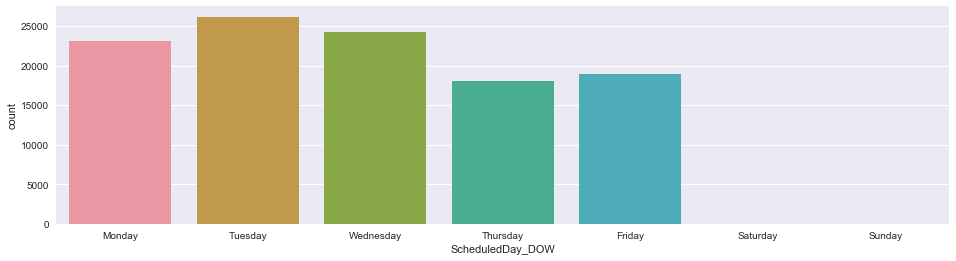

In [128]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df.ScheduledDay_DOW, order=week_key)

- Looks like the call center that takes the appointments doesn't work over the weekends as we do not see any appointments taken on `Saturday` and `Sunday'.

#### 5.11 AppointmentDay_DOW

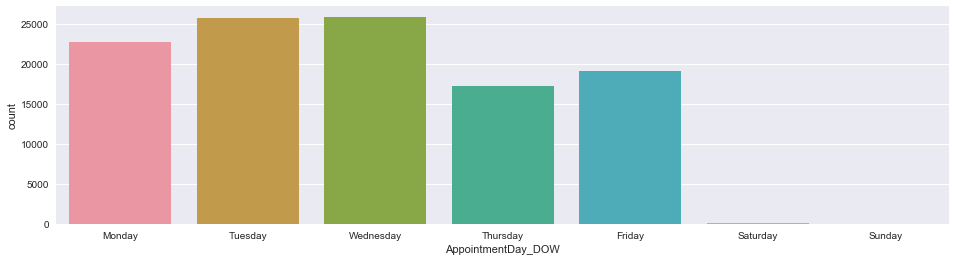

In [129]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df.AppointmentDay_DOW, order=week_key)

- There looks like a pattern with the appointments from the above visualizations. Also, we can see there are very less appointments on `Saturday` and no appointments on `Sunday`.

So, AppointmentDay_DOW could help in determining if a patient visits the hospital after taking an appointment.

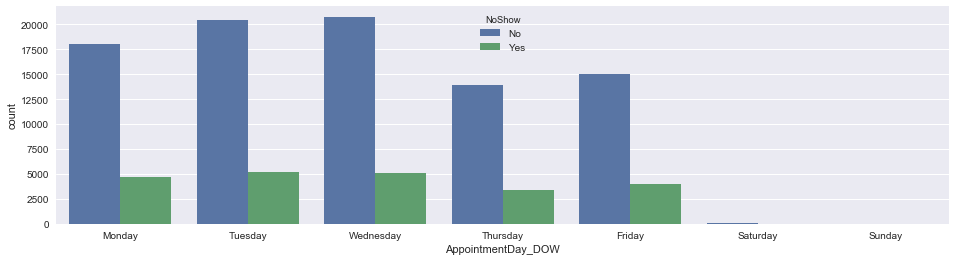

In [130]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df.AppointmentDay_DOW, hue=df.NoShow, order=week_key)

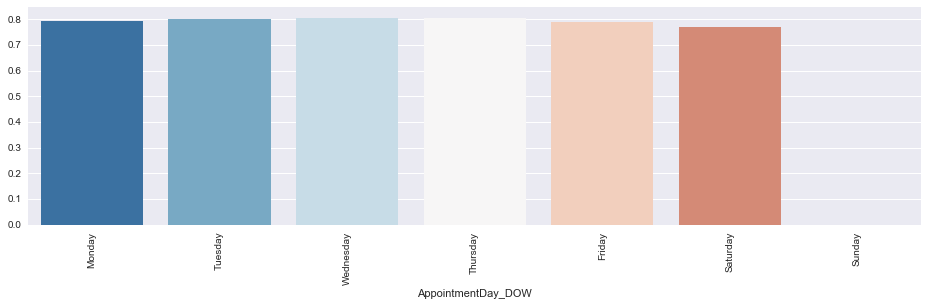

In [131]:
df_a_dow_ratio = df[df.NoShow == 'No'].groupby(['AppointmentDay_DOW']).size()/df.groupby(['AppointmentDay_DOW']).size()
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
_ = sns.barplot(x=df_a_dow_ratio.index, y=df_a_dow_ratio, order=week_key, palette="RdBu_r")

- As we predicted earlier, we do not see a clear pattern in the patients visits based on the week day. But we can observe that on Saturday's the percentage of visits is less. So, AppointmentDay_DOW can help us in predicting the visits by a small number.

#### 5.12 Waiting_Time

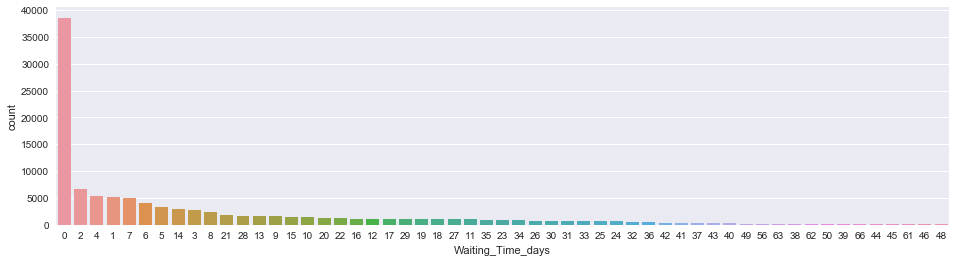

In [132]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df.Waiting_Time_days, order=df.Waiting_Time_days.value_counts().iloc[:55].index)

- From the above visualization we can see that most of the patients are booking their appointments on the same day. The next highest waiting times are 2days, 4 days and 1 day.

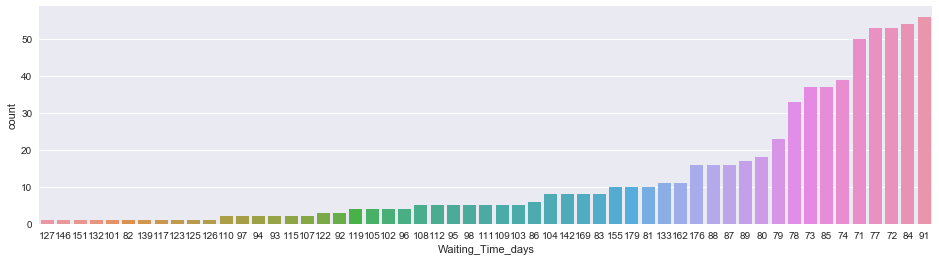

In [133]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df.Waiting_Time_days, order=df.Waiting_Time_days.value_counts(ascending=True).iloc[:55].index)

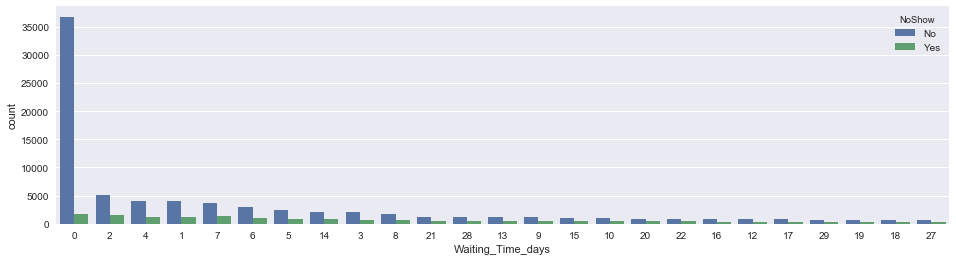

In [134]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df.Waiting_Time_days, hue=df.NoShow, order=df.Waiting_Time_days.value_counts().iloc[:25].index)

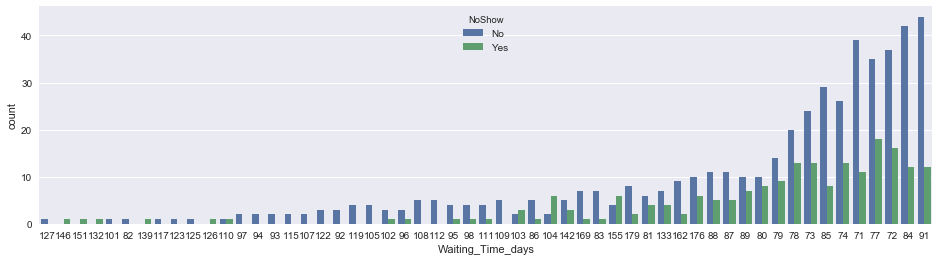

In [135]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df.Waiting_Time_days, hue=df.NoShow, order=df.Waiting_Time_days.value_counts(ascending=True).iloc[:55].index)

- Below we will visualize the last few rows (High WaitTime) for the Waiting_Time_days column.

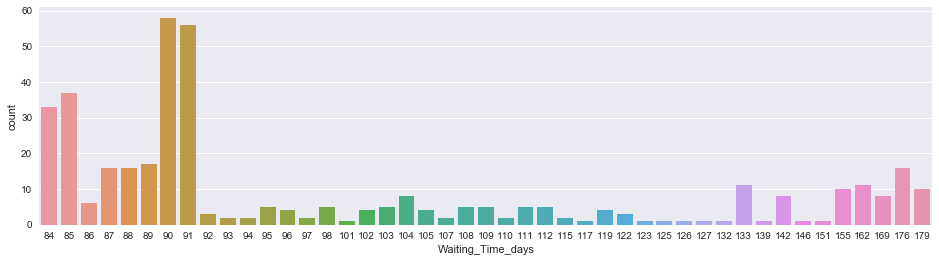

In [136]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df[['Waiting_Time_days']].sort_values('Waiting_Time_days', ascending=False).Waiting_Time_days.iloc[:400])

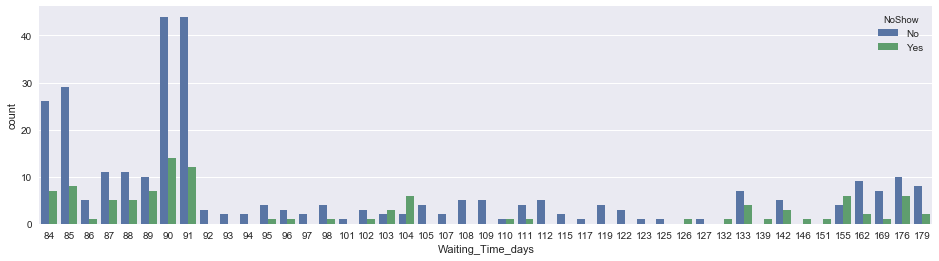

In [137]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df[['Waiting_Time_days']].sort_values('Waiting_Time_days', ascending=False).Waiting_Time_days.iloc[:400], hue=df.NoShow)

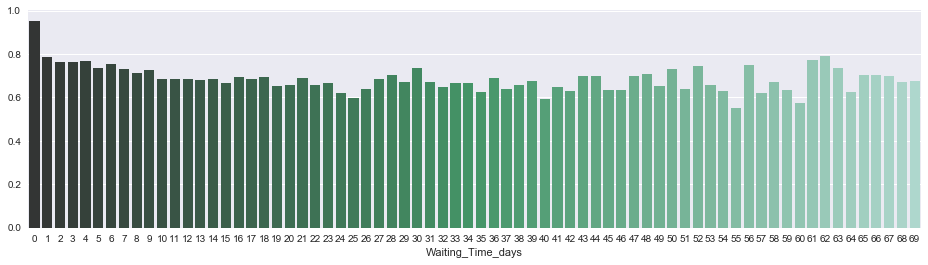

In [138]:
df_w_ratio = df[df.NoShow == 'No'].groupby(['Waiting_Time_days']).size()/df.groupby(['Waiting_Time_days']).size()

plt.figure(figsize=(16,4))
_ = sns.barplot(x=df_w_ratio.index, y=df_w_ratio, order=df.Waiting_Time_days.iloc[:70].index, palette="BuGn_d")

From the above visualization we can see that around 95% of the patients who have booked their appointments on the same day and visiting the hospital without fail. Also close to 80% of the patients are visiting the hospital if they had booked their appointments just before 4 days.

As we have a clear distinction for the patients Show/NoShow with the Waiting_Time_days feature this indeed should help us with a better prediction.

### 6. Model Building

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 15 columns):
Gender                110526 non-null object
ScheduledDay          110526 non-null datetime64[ns]
AppointmentDay        110526 non-null datetime64[ns]
Age                   110526 non-null int64
Neighbourhood         110526 non-null object
Scholarship           110526 non-null object
Hypertension          110526 non-null object
Diabetes              110526 non-null object
Alcoholism            110526 non-null object
Handicap              110526 non-null object
SMSReceived           110526 non-null object
NoShow                110526 non-null object
ScheduledDay_DOW      110526 non-null object
AppointmentDay_DOW    110526 non-null object
Waiting_Time_days     110526 non-null int64
dtypes: datetime64[ns](2), int64(2), object(11)
memory usage: 18.5+ MB


In [140]:
# Use `LabelEncoder` to encode labels with value between 0 and n_classes-1.
#Gender
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
#Neighbourhood
le = LabelEncoder()
df['Neighbourhood'] = le.fit_transform(df['Neighbourhood'])
#ScheduledDay_DOW
le = LabelEncoder()
df['ScheduledDay_DOW'] = le.fit_transform(df['ScheduledDay_DOW'])
#AppointmentDay_DOW
le = LabelEncoder()
df['AppointmentDay_DOW'] = le.fit_transform(df['AppointmentDay_DOW'])
print("LabelEncoder Completed")

#NoShow
le = LabelEncoder()
df['NoShow'] = le.fit_transform(df['NoShow'])

LabelEncoder Completed


In [141]:
df['ScheduledDay_Y'] = df['ScheduledDay'].dt.year
df['ScheduledDay_M'] = df['ScheduledDay'].dt.month
df['ScheduledDay_D'] = df['ScheduledDay'].dt.day
df.drop(['ScheduledDay'], axis=1, inplace=True)

df['AppointmentDay_Y'] = df['AppointmentDay'].dt.year
df['AppointmentDay_M'] = df['AppointmentDay'].dt.month
df['AppointmentDay_D'] = df['AppointmentDay'].dt.day
df.drop(['AppointmentDay'], axis=1, inplace=True)

In [142]:
df.sample(n=10)

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,ScheduledDay_DOW,AppointmentDay_DOW,Waiting_Time_days,ScheduledDay_Y,ScheduledDay_M,ScheduledDay_D,AppointmentDay_Y,AppointmentDay_M,AppointmentDay_D
67427,0,61,38,0,0,0,0,0,1,0,3,3,70,2016,3,3,2016,5,12
102156,0,31,14,0,0,0,0,0,1,0,4,0,10,2016,5,24,2016,6,3
22442,1,0,50,0,0,0,0,0,0,0,4,4,0,2016,5,3,2016,5,3
81506,0,93,2,0,0,0,0,0,0,0,3,3,21,2016,4,28,2016,5,19
65926,0,70,78,0,1,0,0,0,0,0,4,4,0,2016,5,17,2016,5,17
62241,0,68,37,0,0,0,0,0,0,0,4,4,0,2016,5,10,2016,5,10
89377,0,33,50,1,0,0,1,0,0,1,5,1,12,2016,5,25,2016,6,6
384,1,63,15,0,1,0,1,0,0,0,0,0,0,2016,4,29,2016,4,29
55638,0,24,9,0,0,0,0,0,1,1,5,4,6,2016,4,27,2016,5,3
1336,0,74,9,0,1,0,0,0,0,0,3,0,1,2016,4,28,2016,4,29


**From the basic EDA we see that there are around 80% of the patients who have turned up. We see a clear class imbalance problem here. A naive approach of predicting that every one shows up gives us an accuracy of 0.8. Below we shall see how well the classifiers score on this dataset.**

In [143]:
# Get the Dependent and Independent Features.
X = df.drop(['NoShow'], axis=1)
y = df['NoShow']

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

#### 6.1 DecisionTreeClassifier

In [145]:
dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [146]:
print("Feature Importance:\n")
for name, importance in zip(X.columns, np.sort(dt_clf.feature_importances_)[::-1]):
    print("{} -- {:.2f}".format(name, importance))

Feature Importance:

Gender -- 0.23
Age -- 0.23
Neighbourhood -- 0.17
Scholarship -- 0.08
Hypertension -- 0.07
Diabetes -- 0.05
Alcoholism -- 0.05
Handicap -- 0.04
SMSReceived -- 0.02
ScheduledDay_DOW -- 0.02
AppointmentDay_DOW -- 0.01
Waiting_Time_days -- 0.01
ScheduledDay_Y -- 0.01
ScheduledDay_M -- 0.01
ScheduledDay_D -- 0.01
AppointmentDay_Y -- 0.01
AppointmentDay_M -- 0.00
AppointmentDay_D -- 0.00


In [147]:
dt_clf.score(X_test, y_test)

0.72341942205406595

#### 6.2 RandomForestClassifier

In [148]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [149]:
print("Feature Importance:\n")
for name, importance in zip(X.columns, np.sort(rf_clf.feature_importances_)[::-1]):
    print("{} -- {:.2f}".format(name, importance))

Feature Importance:

Gender -- 0.30
Age -- 0.26
Neighbourhood -- 0.12
Scholarship -- 0.06
Hypertension -- 0.05
Diabetes -- 0.03
Alcoholism -- 0.03
Handicap -- 0.03
SMSReceived -- 0.02
ScheduledDay_DOW -- 0.02
AppointmentDay_DOW -- 0.01
Waiting_Time_days -- 0.01
ScheduledDay_Y -- 0.01
ScheduledDay_M -- 0.01
ScheduledDay_D -- 0.01
AppointmentDay_Y -- 0.01
AppointmentDay_M -- 0.00
AppointmentDay_D -- 0.00


In [150]:
rf_clf.score(X_test, y_test)

0.77866425398914296

#### 6.3 GridSearchCV

In [151]:
params={'n_estimators':[10,20], 'max_depth':[None, 5], 'min_samples_split':[2,3]}
rf_clf = RandomForestClassifier(random_state=0)
clf_grid = GridSearchCV(rf_clf, params, cv=5, n_jobs=-1, verbose=1)
clf_grid.fit(X, y)
print(clf_grid.best_params_)
print(clf_grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   18.1s finished


{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.798065613521


From the above Model Score we can see that we are doing almost similar to the naive predictor. Also, as we have imbalanced classes, we should ideally use different metric like `F1-Score` rather than `Accuracy`.

#### 7. Conclusion

From the above feature importance, we could see that `Gender`, `Age`, `Neighbourhood`, `Scholarship` and `Hypertension` are some of the top features that would help us determine if the patient who has taken an appointment will Show/NoShow.